In [2]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.utils import to_categorical


In [3]:
data = pd.read_csv(r"combined_all.csv")
data[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [4]:

# Attack types you want to merge
webattack_labels = [
    "Web Attack � Brute Force",
    "Web Attack � XSS",
    "Web Attack � Sql Injection",
    "Infiltration","Heartbleed"
]

# Replace them with "WebAttack"
data[' Label'] = data[' Label'].replace(webattack_labels, "WebAttack")

# Check results
data[' Label'].value_counts()


 Label
BENIGN              2273097
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
FTP-Patator            7938
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
WebAttack              2227
Bot                    1966
Name: count, dtype: int64

In [5]:
data1=data

In [6]:
# remove spaces around column names
data.columns = data.columns.str.strip()

# fix label column
data = data.rename(columns={"Label": "Label"})


In [7]:
for col in data.columns:
    if data[col].dtype == 'object' and col != "Label":
        data[col] = pd.to_numeric(data[col], errors='coerce')


In [8]:
import numpy as np
data = data.replace([np.inf, -np.inf], np.nan)


In [9]:
data = data.dropna()


In [10]:

import numpy as np
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(data.median(numeric_only=True))
# ----------------------------------

print("Cleaned inf/nan values.\n")
print(data.isin([np.inf, -np.inf]).sum().sum())   # should print 0


Cleaned inf/nan values.

0


In [11]:
from imblearn.under_sampling import TomekLinks


In [12]:
# 2) TARGET SIZES
# =====================================================
BENIGN_TARGET = 150000
ANOMALY_TARGET = 15000

balanced_list = []

# =====================================================
# 3) DOWNSAMPLE BENIGN
# =====================================================
data_benign = data[data["Label"] == "BENIGN"]
data_benign_down = data_benign.sample(n=BENIGN_TARGET, random_state=42)

balanced_list.append(data_benign_down)
print(f"BENIGN ↓ {len(data_benign)} → {BENIGN_TARGET}\n")

# =====================================================
# 4) PROCESS ANOMALY CLASSES
# =====================================================
data_anomaly = data[data["Label"] != "BENIGN"]
class_groups = dict(tuple(data_anomaly.groupby("Label")))

print("Processing anomaly classes...\n")

temp_anomaly_list = []

for cls, subset in class_groups.items():
    count = len(subset)
    print(f"Class: {cls}  |  Count: {count}")

    # ---- Case A: Downsample large classes ----
    if count > ANOMALY_TARGET:
        down = subset.sample(n=ANOMALY_TARGET, random_state=42)
        temp_anomaly_list.append(down)
        print(f"  ↓ Downsampled {cls}: {count} → {ANOMALY_TARGET}\n")
        continue

    # ---- Case B: Exact ----
    if count == ANOMALY_TARGET:
        temp_anomaly_list.append(subset)
        print(f"  = Kept {cls} at {ANOMALY_TARGET}\n")
        continue

    # ---- Case C: Small classes (try SMOTE, but safe mode) ----
    X = subset.drop("Label", axis=1)
    y = subset["Label"]

    # If only 1 unique row → SMOTE impossible
    if len(X.drop_duplicates()) < 2:
        print(f"  !! Cannot SMOTE {cls}: Only {len(X.drop_duplicates())} unique row(s). Duplicating instead.")
        repeat_times = ANOMALY_TARGET // len(subset) + 1
        df_res = pd.concat([subset] * repeat_times, ignore_index=True).head(ANOMALY_TARGET)
        temp_anomaly_list.append(df_res)
        print(f"  ↑ Duplicated {cls}: {count} → {ANOMALY_TARGET}\n")
        continue

    # Try SMOTE safely
    try:
        smote = SMOTE(sampling_strategy={cls: ANOMALY_TARGET}, random_state=42)
        X_res, y_res = smote.fit_resample(X, y)

        df_res = pd.DataFrame(X_res, columns=X.columns)
        df_res["Label"] = y_res

        temp_anomaly_list.append(df_res)
        print(f"  ↑ SMOTEd {cls}: {count} → {ANOMALY_TARGET}\n")

    except Exception as e:
        print(f"  !! SMOTE failed for {cls}: {e}")
        print("  !! Fallback to duplication.")

        repeat_times = ANOMALY_TARGET // len(subset) + 1
        df_res = pd.concat([subset] * repeat_times, ignore_index=True).head(ANOMALY_TARGET)
        temp_anomaly_list.append(df_res)
        print(f"  ↑ Duplicated {cls}: {count} → {ANOMALY_TARGET}\n")

# =====================================================
# 5) MERGE ALL ANOMALIES
# =====================================================
all_anomalies = pd.concat(temp_anomaly_list, ignore_index=True)

# =====================================================
# 6) CLEAN WITH TOMEK LINKS
# =====================================================
X_all = all_anomalies.drop("Label", axis=1)
y_all = all_anomalies["Label"]

tl = TomekLinks()
X_clean, y_clean = tl.fit_resample(X_all, y_all)

anomaly_final = pd.DataFrame(X_clean, columns=X_all.columns)
anomaly_final["Label"] = y_clean

# =====================================================
# 7) MERGE BENIGN + ANOMALIES
# =====================================================
data_final = pd.concat([data_benign_down, anomaly_final], ignore_index=True)
data_final = data_final.sample(frac=1, random_state=42).reset_index(drop=True)

# =====================================================
# 8) SAVE
# =====================================================
output_file = "BALANCED_SMOTE_TOMEK.csv"
data_final.to_csv(output_file, index=False)

print("\nSaved final balanced dataset:", output_file)
print("\nFinal Class Distribution:")
print(data_final["Label"].value_counts())

BENIGN ↓ 2271320 → 150000

Processing anomaly classes...

Class: Bot  |  Count: 1956
  !! SMOTE failed for Bot: name 'SMOTE' is not defined
  !! Fallback to duplication.
  ↑ Duplicated Bot: 1956 → 15000

Class: DDoS  |  Count: 128025
  ↓ Downsampled DDoS: 128025 → 15000

Class: DoS GoldenEye  |  Count: 10293
  !! SMOTE failed for DoS GoldenEye: name 'SMOTE' is not defined
  !! Fallback to duplication.
  ↑ Duplicated DoS GoldenEye: 10293 → 15000

Class: DoS Hulk  |  Count: 230124
  ↓ Downsampled DoS Hulk: 230124 → 15000

Class: DoS Slowhttptest  |  Count: 5499
  !! SMOTE failed for DoS Slowhttptest: name 'SMOTE' is not defined
  !! Fallback to duplication.
  ↑ Duplicated DoS Slowhttptest: 5499 → 15000

Class: DoS slowloris  |  Count: 5796
  !! SMOTE failed for DoS slowloris: name 'SMOTE' is not defined
  !! Fallback to duplication.
  ↑ Duplicated DoS slowloris: 5796 → 15000

Class: FTP-Patator  |  Count: 7935
  !! SMOTE failed for FTP-Patator: name 'SMOTE' is not defined
  !! Fallback t

In [13]:
# diagnostic: compare class counts before and after TomekLinks
print("Counts in all_anomalies (before TomekLinks):")
counts_before = all_anomalies["Label"].value_counts()
print(counts_before, "\n")

print("Counts in anomaly_final (after TomekLinks):")
counts_after = anomaly_final["Label"].value_counts()
print(counts_after, "\n")

# difference
diff = counts_before.reindex(counts_before.index).fillna(0) - counts_after.reindex(counts_before.index).fillna(0)
print("Removed by TomekLinks (before - after):")
print(diff[diff != 0].sort_values(ascending=False), "\n")

# classes fully removed
removed_classes = list(counts_before.index.difference(counts_after.index))
if removed_classes:
    print("Classes fully removed by TomekLinks:", removed_classes)
else:
    print("No classes fully removed.")


Counts in all_anomalies (before TomekLinks):
Label
Bot                 15000
DDoS                15000
DoS GoldenEye       15000
DoS Hulk            15000
DoS Slowhttptest    15000
DoS slowloris       15000
FTP-Patator         15000
PortScan            15000
SSH-Patator         15000
WebAttack           15000
Name: count, dtype: int64 

Counts in anomaly_final (after TomekLinks):
Label
Bot                 15000
DoS slowloris       15000
WebAttack           15000
DoS Slowhttptest    15000
SSH-Patator         15000
FTP-Patator         15000
DoS GoldenEye       14999
PortScan            14997
DDoS                14976
DoS Hulk            14974
Name: count, dtype: int64 

Removed by TomekLinks (before - after):
Label
DoS Hulk         26
DDoS             24
PortScan          3
DoS GoldenEye     1
Name: count, dtype: int64 

No classes fully removed.


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.utils import to_categorical


In [15]:
data = pd.read_csv("BALANCED_SMOTE_TOMEK.csv")

print("Loaded dataset shape:", data.shape)
print(data["Label"].value_counts())


Loaded dataset shape: (299946, 79)
Label
BENIGN              150000
FTP-Patator          15000
Bot                  15000
DoS Slowhttptest     15000
WebAttack            15000
DoS slowloris        15000
SSH-Patator          15000
DoS GoldenEye        14999
PortScan             14997
DDoS                 14976
DoS Hulk             14974
Name: count, dtype: int64


In [16]:
# Split features / target
X = data.drop("Label", axis=1).values
y = data["Label"]

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM / GRU (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

num_classes = y_cat.shape[1]
input_dim = X_train.shape[2]
# Convert input shape for RandomForest (remove timestep dimension)
X_train_rf = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_rf  = X_test.reshape(X_test.shape[0], X_test.shape[2])

# Convert one-hot labels to integer labels
y_train_rf = np.argmax(y_train, axis=1)
y_test_rf  = np.argmax(y_test, axis=1)



In [17]:
from sklearn.ensemble import RandomForestClassifier

def build_randomforest():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )


In [18]:
def build_lstm(input_dim, num_classes):
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(1, input_dim)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [19]:
def build_gru(input_dim, num_classes):
    model = Sequential()
    model.add(GRU(128, return_sequences=False, input_shape=(1, input_dim)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [20]:
def build_hybrid(input_dim, num_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(1, input_dim)))
    model.add(GRU(64))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [21]:
history_dict = {}
results_dict = {}

models = {
    "LSTM": build_lstm(input_dim, num_classes),
    "GRU": build_gru(input_dim, num_classes),
    "Hybrid_LSTM_GRU": build_hybrid(input_dim, num_classes),
    "RandomForest": build_randomforest()
}


for name, model in models.items():
    print(f"\n================ TRAINING {name} ================\n")
    
    if name != "RandomForest":
        # Train neural network
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=256,
            validation_split=0.2,
            verbose=1
        )
        
        history_dict[name] = history
        
        y_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)
    
    else:
        # Train RandomForest
        model.fit(X_train_rf, y_train_rf)
        
        y_pred_labels = model.predict(X_test_rf)
        y_true_labels = y_test_rf
        
        history_dict[name] = None  # RF has no history
    
    # Calculate accuracy
    acc = accuracy_score(y_true_labels, y_pred_labels)
    results_dict[name] = acc
    
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

c:\Users\91630\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



================ TRAINING LSTM ================

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8617 - loss: 0.4528 - val_accuracy: 0.9435 - val_loss: 0.1699
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9471 - loss: 0.1571 - val_accuracy: 0.9598 - val_loss: 0.1174
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9565 - loss: 0.1226 - val_accuracy: 0.9592 - val_loss: 0.1025
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9607 - loss: 0.1091 - val_accuracy: 0.9662 - val_loss: 0.0939
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9631 - loss: 0.1014 - val_accuracy: 0.9666 - val_loss: 0.0914
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9644 - loss: 0.0967 - val_accuracy: 0.9683 - val_loss: 0.0887
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9659 - loss: 0.0935 - val_accuracy: 0.9686 - val_loss: 0.0870
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - 

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate
import pandas as pd

performance_rows = []

for name in models.keys():
    
    # Get predictions
    if name != "RandomForest":
        y_pred = models[name].predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)
    else:
        y_pred_labels = models[name].predict(X_test_rf)
        y_true_labels = y_test_rf

    # Compute metrics
    acc = accuracy_score(y_true_labels, y_pred_labels)
    ppv = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    tpr = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    f1  = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)

    performance_rows.append([
        name,
        round(acc, 4),
        round(ppv, 4),
        round(tpr, 4),
        round(f1, 4)
    ])

# Create DataFrame
results_table = pd.DataFrame(performance_rows, columns=["Method", "ACC", "PPV", "TPR", "F1"])

# Print neatly formatted table
print(tabulate(results_table, headers='keys', tablefmt='fancy_grid', showindex=False))


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 963us/step
╒═════════════════╤════════╤════════╤════════╤════════╕
│ Method          │    ACC │    PPV │    TPR │     F1 │
╞═════════════════╪════════╪════════╪════════╪════════╡
│ LSTM            │ 0.9723 │ 0.9589 │ 0.9817 │ 0.9696 │
├─────────────────┼────────┼────────┼────────┼────────┤
│ GRU             │ 0.9696 │ 0.9569 │ 0.9758 │ 0.9657 │
├─────────────────┼────────┼────────┼────────┼────────┤
│ Hybrid_LSTM_GRU │ 0.9683 │ 0.9486 │ 0.9837 │ 0.965  │
├─────────────────┼────────┼────────┼────────┼────────┤
│ RandomForest    │ 0.9989 │ 0.9989 │ 0.9989 │ 0.9989 │
╘═════════════════╧════════╧════════╧════════╧════════╛


In [23]:
import pandas as pd

# 1️⃣ Feature names come directly from your main DataFrame
feature_names = data.drop("Label", axis=1).columns.tolist()

# 2️⃣ Get RF feature importances
rf_model = models["RandomForest"]        # trained RandomForest
importances = rf_model.feature_importances_

# 3️⃣ Build DataFrame
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# 4️⃣ Sort features by importance
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

print("\n===================== RANDOM FOREST FEATURE IMPORTANCE =====================\n")
print(feat_imp_df)

# 5️⃣ Select top K features
top_k = 15    # you can change this
top_features = feat_imp_df.head(top_k)

print(f"\n===================== TOP {top_k} FEATURES =====================\n")
print(top_features)



===================== RANDOM FOREST FEATURE IMPORTANCE =====================

                    Feature  Importance
0          Destination Port    0.084780
66   Init_Win_bytes_forward    0.052083
67  Init_Win_bytes_backward    0.040997
13    Bwd Packet Length Std    0.027654
42   Packet Length Variance    0.022536
..                      ...         ...
60     Bwd Avg Packets/Bulk    0.000000
57     Fwd Avg Packets/Bulk    0.000000
56       Fwd Avg Bytes/Bulk    0.000000
59       Bwd Avg Bytes/Bulk    0.000000
58        Fwd Avg Bulk Rate    0.000000

[78 rows x 2 columns]

===================== TOP 15 FEATURES =====================

                    Feature  Importance
0          Destination Port    0.084780
66   Init_Win_bytes_forward    0.052083
67  Init_Win_bytes_backward    0.040997
13    Bwd Packet Length Std    0.027654
42   Packet Length Variance    0.022536
12   Bwd Packet Length Mean    0.021967
54     Avg Bwd Segment Size    0.021438
41        Packet Length Std    0.021

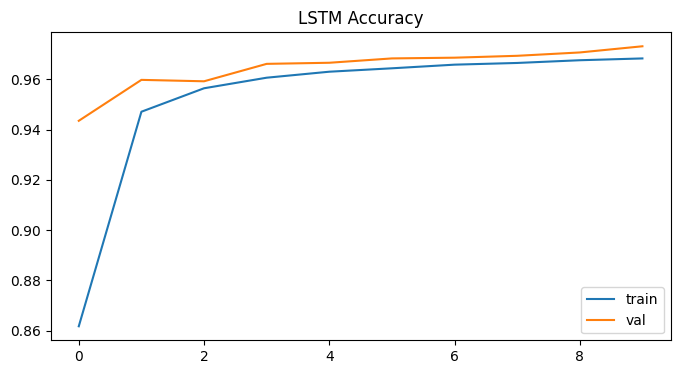

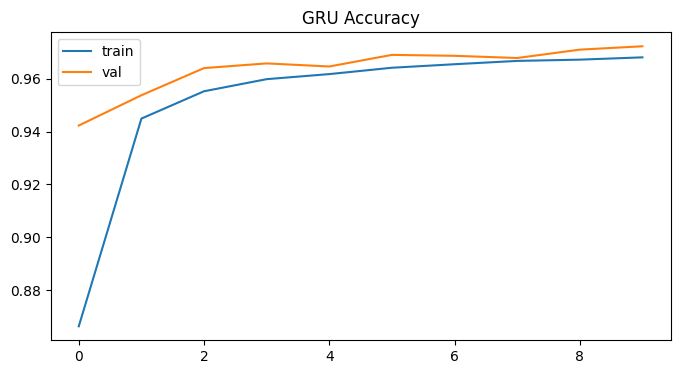

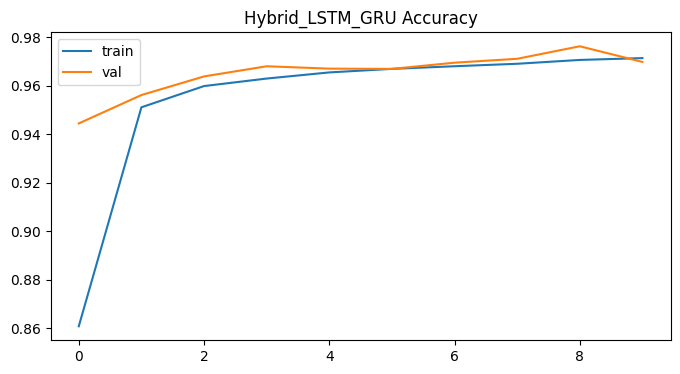

RandomForest has no training history (skipping).


In [24]:
import matplotlib.pyplot as plt

for name, hist in history_dict.items():
    
    # Skip RandomForest (it has no history)
    if hist is None:
        print(f"{name} has no training history (skipping).")
        continue
    
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title(f'{name} Accuracy')
    plt.legend(['train','val'])
    plt.show()


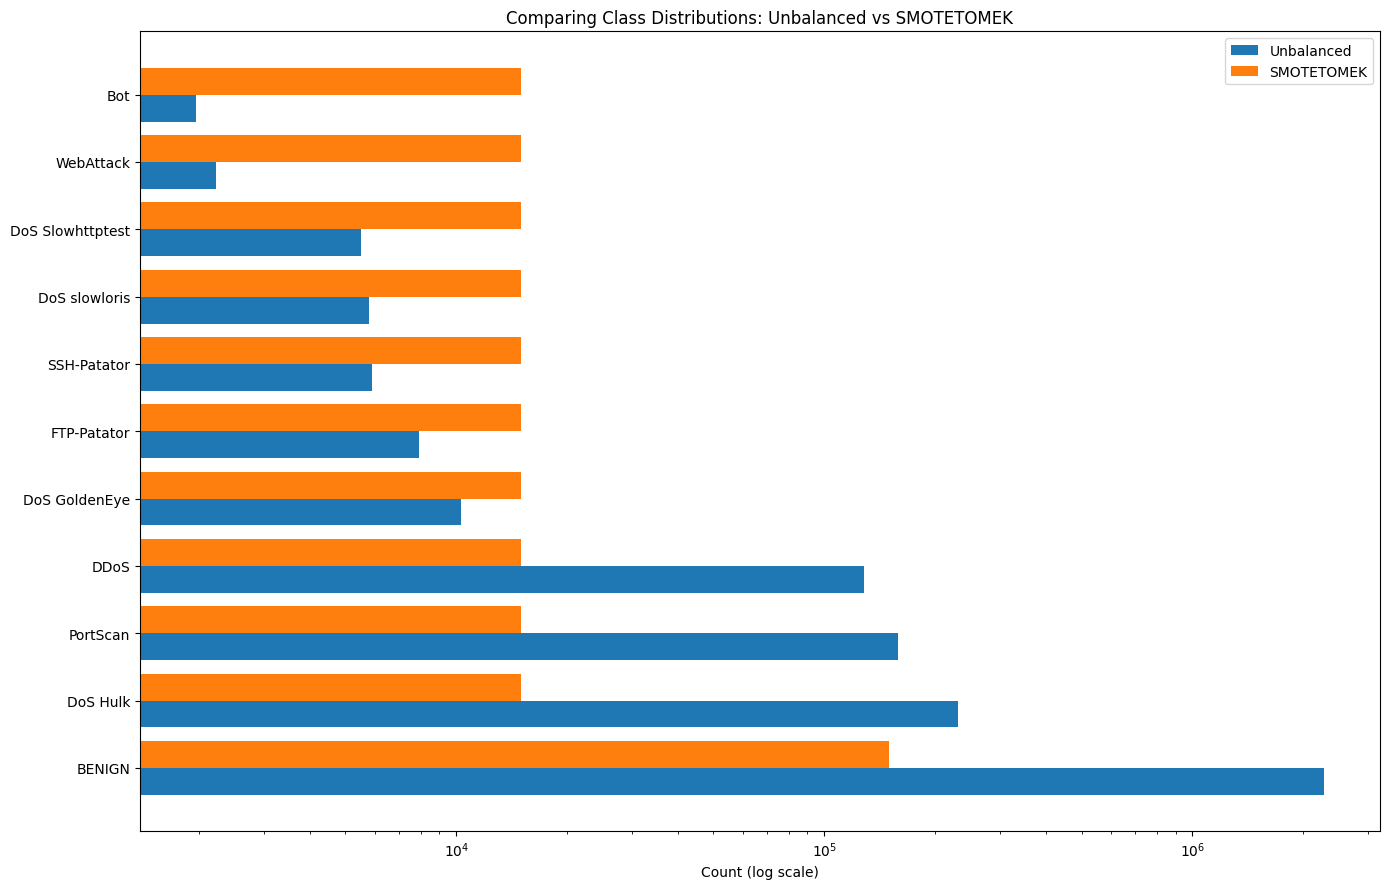

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Get value counts
vc1 = data['Label'].value_counts()
vc = data1['Label'].value_counts()

# Align labels so both datasets have same order
labels = vc.index
vc1 = vc1.reindex(labels).fillna(0)

# Bar positions
y = np.arange(len(labels))
height = 0.4  # bar thickness

plt.figure(figsize=(14, 9))

# Plot side-by-side bars
plt.barh(y - height/2, vc.values, height, label='Unbalanced')
plt.barh(y + height/2, vc1.values, height, label='SMOTETOMEK')

# ★ SCALE ADJUSTMENT ★
plt.xscale('log')   

# Labels & formatting
plt.yticks(y, labels)
plt.xlabel("Count (log scale)")
plt.title("Comparing Class Distributions: Unbalanced vs SMOTETOMEK")
plt.legend()

plt.tight_layout()
plt.show()


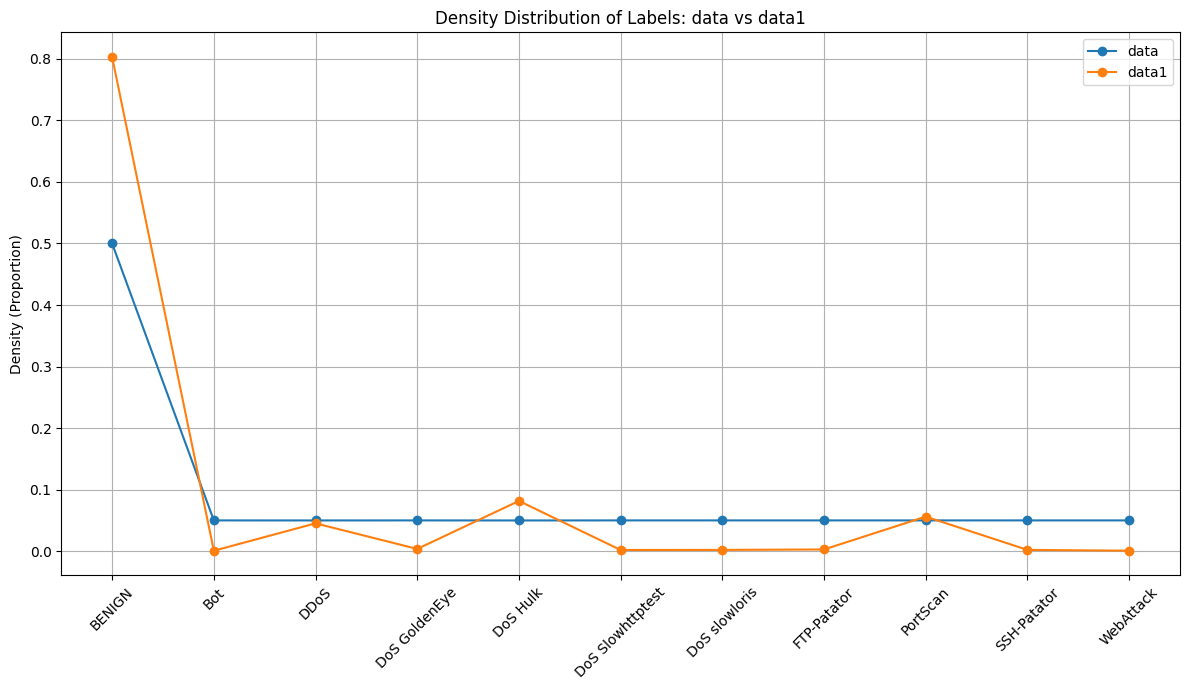

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get normalized proportions
vc_data  = data['Label'].value_counts(normalize=True)
vc_data1 = data1['Label'].value_counts(normalize=True)

# Align categories
labels = sorted(set(vc_data.index).union(vc_data1.index))

vals_data  = np.array([vc_data.get(lbl, 0) for lbl in labels])
vals_data1 = np.array([vc_data1.get(lbl, 0) for lbl in labels])

x = np.arange(len(labels))

plt.figure(figsize=(12, 7))

# Plot as smoothable density lines
plt.plot(x, vals_data, marker='o', label='data')
plt.plot(x, vals_data1, marker='o', label='data1')

plt.xticks(x, labels, rotation=45)
plt.ylabel("Density (Proportion)")
plt.title("Density Distribution of Labels: data vs data1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
